<a href="https://colab.research.google.com/github/FelipeCatalanPerez/Modelo-clasificador-de-correos-SPAM/blob/main/ClasificadoCorreos_FelipeCatalan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo clasificador de correos SPAM
## Tarea 1
1. Autor: *Felipe Catalán*
2. Fecha: 22/01/2023
3. Info del Dataset [Spam](https://www.openml.org/search?type=data&sort=runs&status=active&id=44):

### Info Variables

La última columna indica si el correo electrónico se consideró spam (1) o no (0), es decir, correo electrónico comercial no solicitado. La mayoría de los atributos indican si una palabra o carácter en particular aparecía con frecuencia en el correo electrónico. Los atributos de longitud de ejecución (55-57) miden la longitud de secuencias de letras mayúsculas consecutivas.

48 atributos reales continuos [0,100] de tipo
`palabra_freq_PALABRA` = porcentaje de palabras en el correo electrónico que coinciden con PALABRA, es decir, 100 * (número de veces que aparece la PALABRA en el correo electrónico) / número total de palabras en el correo electrónico. Una "palabra" en este caso es cualquier cadena de caracteres alfanuméricos limitada por caracteres no alfanuméricos o al final de la cadena.

6 atributos reales continuos [0,100] de tipo `char_freq_CHAR` = porcentaje de caracteres en el correo electrónico que coinciden con CHAR, es decir, 100 * (número de ocurrencias de CHAR) / caracteres totales en el correo electrónico

1 atributo real continuo [1,...] de tipo `capital_run_length_average` = longitud promedio de secuencias ininterrumpidas de letras mayúsculas

1 entero continuo [1,...] atributo de tipo `capital_run_length_longest` = longitud de la secuencia ininterrumpida más larga de letras mayúsculas

1 entero continuo [1,...] atributo de tipo `capital_run_length_total` = suma de longitud de secuencias ininterrumpidas de letras mayúsculas = número total de letras mayúsculas en el correo electrónico

1 atributo de clase nominal {0,1} de tipo `spam` = indica si el correo electrónico se consideró spam (1) o no (0), es decir, correo electrónico comercial no solicitado.

### Librerias

In [ ]:
from scipy.io import arff                              # Para cargar la data
import urllib.request
import io                                              # for io.StringIO()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split   # Para separar datos en entrenamiento y evaluación
from sklearn.metrics import confusion_matrix           # Para crear matriz de confusion
SEED=42                                                # Semilla para replicar resultados

-----------------------------------------

# 1. Datos

## 1.1 Importar datos

Se armo una función que con una URL descarga el dataset, realiza un preproceso y lo ordena.

- X es una matriz.
- Y es un vector discreto (clasificacion).
- Y es un vector continuo (regresion).

itos es un diccionario creado para no olvidar a que corresponden las categorias de Y. Se siguio el mismo procedimiento propuesto dado que `value` tiene gran importancia cuando se corren los modelos.

In [ ]:
DATA_SOURCE = "https://www.openml.org/data/download/44/dataset_44_spambase.arff"

def load_spam_web(URL=DATA_SOURCE):
  ftpstream = urllib.request.urlopen(URL)
  data, meta = arff.loadarff(io.StringIO(ftpstream.read().decode('utf-8')))
  df = pd.DataFrame(data, columns = meta)
  # Formato
  df = df.astype(float)
  # cambiando nombre de la columna clase, por problemas con el nombre anterior
  df.columns=['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',
       'char_freq_%3B', 'char_freq_%28', 'char_freq_%5B', 'char_freq_%21',
       'char_freq_%24', 'char_freq_%23', 'capital_run_length_average',
       'capital_run_length_longest', 'capital_run_length_total', 'clase']
  # defino una muestra aleatoria de 500 obs, con una semilla de 42
  df1 = df.sample(n=500, random_state=42)
  # Las primeras 57 columnas son input (X) - columna 58 es target (y)
  X, y = df1.iloc[:, 0:57], df1.iloc[:, [57]]
  # Preproceso
  # le doy formato string para generar diccionario y adecuarme al modelo
  y['clase'] = y['clase'].astype('string')
  # Reemplazo los valores para generar diccionario
  y['clase'] = y['clase'].replace("0.0", "NoSpam",regex=True)
  y['clase'] = y['clase'].replace("1.0", "Spam",regex=True)
  # Le doy formato de serie para utilizar funcion "y.unique()"
  y=y.squeeze()
  # Genero diccionario para tener "value" que se usa en el modelo
  itos = {value: key for key, value in zip(y.unique(), [x for x in range(2)])}
  stoi = {value: key for key, value in itos.items()}
  y = y.replace(stoi)
  return {"dataset": (X, y),
          "df": df,
          "df1": df1,
          "itos": itos}

Guardo los datos en la función `load_spam_web`

In [ ]:
data = load_spam_web()
X, y = data['dataset']
df = data['df']
df1 = data['df1']
labels = data['itos']

<ipython-input-59-a654f80aecb3>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['clase'] = y['clase'].astype('string')
<ipython-input-59-a654f80aecb3>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['clase'] = y['clase'].replace("0.0", "NoSpam",regex=True)
<ipython-input-59-a654f80aecb3>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

## 1.2 Explorar datos

Dimencciones del dataset Spam.

In [ ]:
X.shape, y.shape

((500, 57), (500,))

Dos primeras filas para verificar formatos

In [ ]:
X.head(n=2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total
3683,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,1.0,3.0
4412,0.71,0.0,0.71,0.0,0.0,0.0,0.0,0.0,0.0,0.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.032,2.0,32.0


Se observa cuantos tipos de correos puede haber

In [ ]:
df["clase"].unique()

array([1., 0.])

La "clase" o el "Y" se presenta como variable dummy con 0 y 1, gracias a la creacion del diccionario se cuenta con etiquetas para identificarlos mas rapidamente.

In [ ]:
labels

{0: 'NoSpam', 1: 'Spam'}

Ahora vamos a dejar un 20% de la data destinada a evaluar que tan bien se ajusta nuestro modelo.

Fraccionaremos el conjunto de datos de manera aleatoria, para garantizar la reproducibilidad de los resultados utilizaremos el argumento `random_state` dandole una semilla que permite replicar los resultados.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
X_train.shape, X_test.shape

((400, 57), (100, 57))

In [ ]:
y_train.shape, y_test.shape

((400,), (100,))

Finalmente se comenta que no existen valores perdidos en la data.

### 1.2.1. Tablas

Se presenta a continuación un resumen de los estadísticos principales, calculados de la muestra aleatoria de 500 observaciones.

In [ ]:
# Calculos
promedios_df = df1.mean()
Q25_df = df1.quantile(0.25)
Q50_df = df1.quantile(0.50)
Q75_df = df1.quantile(0.75)
min_df = df1.min()
max_df = df1.max()
ds_df = df1.std()

# Confeccion de tabla
Tablaresumen = pd.DataFrame(
    {
        "promedio": promedios_df,
        "1er Cuartil 25%":Q25_df,
        "Mediana":Q50_df,
        "3er Cuartil 75%":Q75_df,
        "Min":min_df,
        "Max":max_df,
        "Desviacion estandar":ds_df
     }
    )
Tablaresumen

,promedio,1er Cuartil 25%,Mediana,3er Cuartil 75%,Min,Max,Desviacion estandar
word_freq_make,0.120160,0.0000,0.0000,0.00000,0.0,4.000,0.366801
word_freq_address,0.231740,0.0000,0.0000,0.00000,0.0,14.280,1.345671
word_freq_all,0.295080,0.0000,0.0000,0.47250,0.0,3.700,0.497816
word_freq_3d,0.118800,0.0000,0.0000,0.00000,0.0,42.810,1.967972
word_freq_our,0.349020,0.0000,0.0000,0.45000,0.0,9.090,0.721843
word_freq_over,0.094040,0.0000,0.0000,0.00000,0.0,2.540,0.264811
word_freq_remove,0.131060,0.0000,0.0000,0.00000,0.0,5.400,0.486209
word_freq_internet,0.111640,0.0000,0.0000,0.00000,0.0,3.970,0.379879
word_freq_order,0.091600,0.0000,0.0000,0.00000,0.0,3.230,0.300146
word_freq_mail,0.228460,0.0000,0.0000,0.17000,0.0,3.770,0.512317


La tabla resumen presentada anteriormente muestra el comportamiento de las 58 variables, a grandes rasgos es visible la gran cantidad de ceros que contiene la data estando presente incluso en el 3er cuartil correspondiente al 75% de la distribución de las variables. Siguiendo con el análisis respecto al promedio destaca la frecuencia de las palabras “you”, “your”, “hp”, “George”, que presentan promedios mas altos a las demás los cuales no se ven alterados por valores outliers que se podrían observar en el máximo. Las variables con una mayor desviación estándar son aquellas que describen el comportamiento de las letras mayúsculas en el correo, aunque esto también se debe a que tienen el mayor valor máximo y lo mismo con su distribución de cuartiles.

In [ ]:
Tabla1 = df1[['clase','word_freq_make']]
Tabla1.columns = ['clase','Número de Obs']
Tabla1 = Tabla1.groupby(by="clase").count()
Tabla1

,Número de Obs
clase,
0.0,290
1.0,210


El modelo clasificador que se conformara en este documento cuenta en la muestra aleatoria con: 
- 290 observaciones de la categoría No Spam
- 210 observaciones de la categoría Spam.

### 1.2.2. Graficos

La siguiente matriz de correlaciones presenta la visualización de las 24 variables que tienen una mayor correlación con la variable a predecir además de incorporar las 3 variables que describen el comportamiento de las letras mayúsculas.

#### Matriz de correlaciones

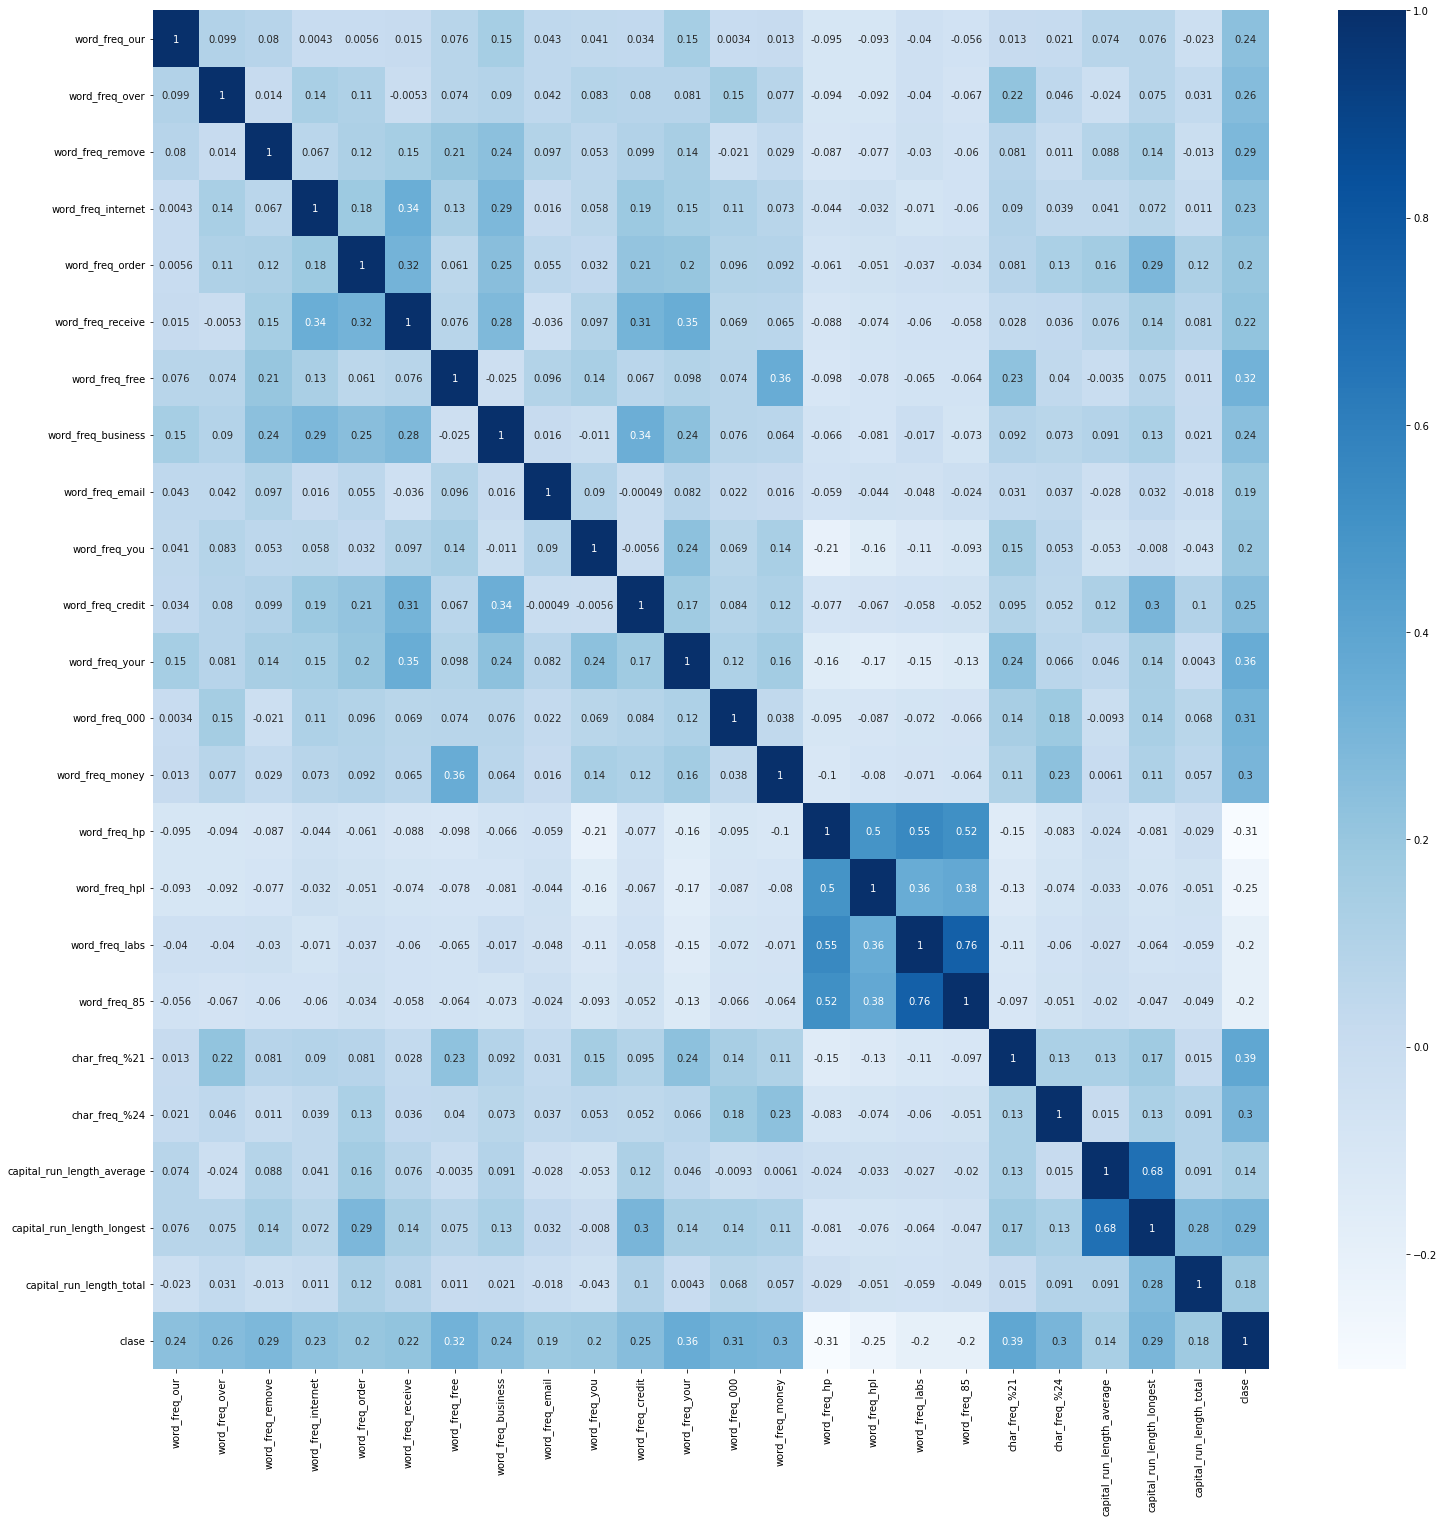

In [ ]:
corr = df1.iloc[:,[4,5,6,7,8,10,15,16,17,18,19,20,22,23,24,25,29,34,51,52,54,55,56,57]].corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr, cmap="Blues",annot=True)

Se observa el grado de relación lineal entre todas las variables, sin embargo, destacan aquellas que tienen un mayor impacto en el comportamiento de la variable a predecir. La frecuencia de las palabras como **“free”**, **“your”**, **“000”**, **“money”** y **“hp”** tienen correlaciones de aprox |0,3|, considerando que el máximo grado de correlación lineal es |1|, estas variables en su conjunto podrían llegar a explicar en gran medida el comportamiento de la variable clase.

#### Graficos de puntos

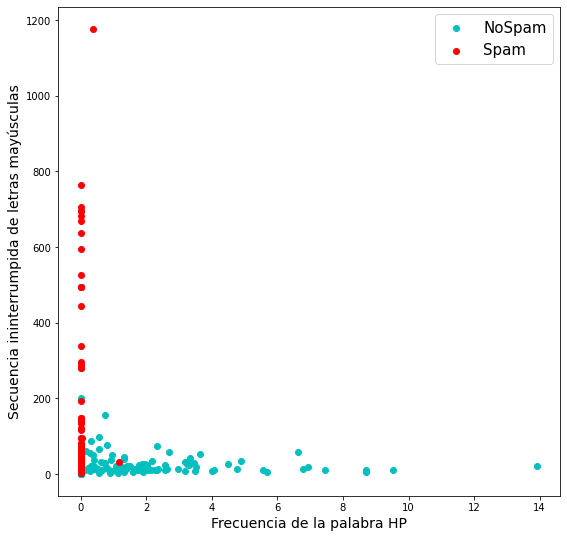

In [ ]:
# esta solo es una visualizacion realizada de forma mas compleja...
plt.figure(figsize=(9, 9));

for k in labels.keys():
  bool_filter = y_train == k
  plt.scatter(X_train['word_freq_hp'][bool_filter], X_train['capital_run_length_longest'][bool_filter], 
              c='cr'[k],
              label=labels[k]);

plt.legend(prop={'size': 15});
plt.xlabel("Frecuencia de la palabra HP", fontsize=14);
plt.ylabel("Secuencia ininterrumpida de letras mayúsculas", fontsize=14);

El grafico anterior muestra cómo se distribuyen las observaciones entre la secuencia ininterrumpida de letras mayúsculas y la frecuencia de repetición de la palabra HP, las observaciones de correos Spam se diferencian a medida en que cobran relevancia estas variables. Esto dado que a mayor frecuencia de la palabra **HP** el correo tiene menos posibilidades de ser Spam y a mayor frecuencia de palabras ininterrumpida de **letras mayúsculas** mayor posibilidad de que el correo sea Spam.

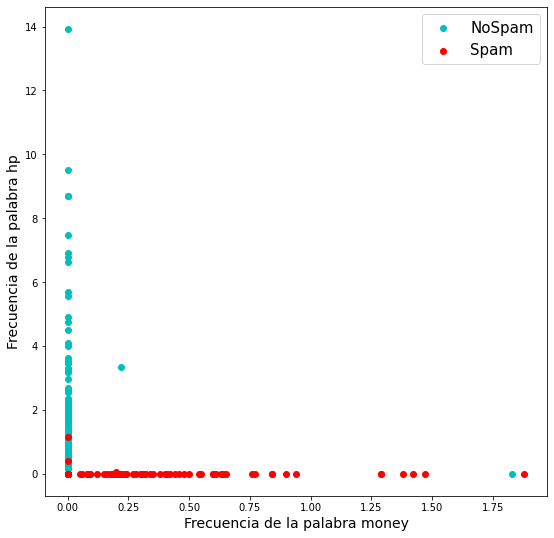

In [ ]:
# esta solo es una visualizacion realizada de forma mas compleja...
plt.figure(figsize=(9, 9));

for k in labels.keys():
  bool_filter = y_train == k
  plt.scatter(X_train['word_freq_money'][bool_filter], X_train['word_freq_hp'][bool_filter], 
              c='cr'[k],
              label=labels[k]);

plt.legend(prop={'size': 15});
plt.xlabel("Frecuencia de la palabra money", fontsize=14);
plt.ylabel("Frecuencia de la palabra hp", fontsize=14);

Complementando con la explicación del grafico anterior esta vez se puede observar que a una mayor frecuencia de aparición de la palabra **money** existen más posibilidades de que el correo sea Spam.

Análisis de las variables con menos cantidad de observaciones cero y mayor desviación estándar

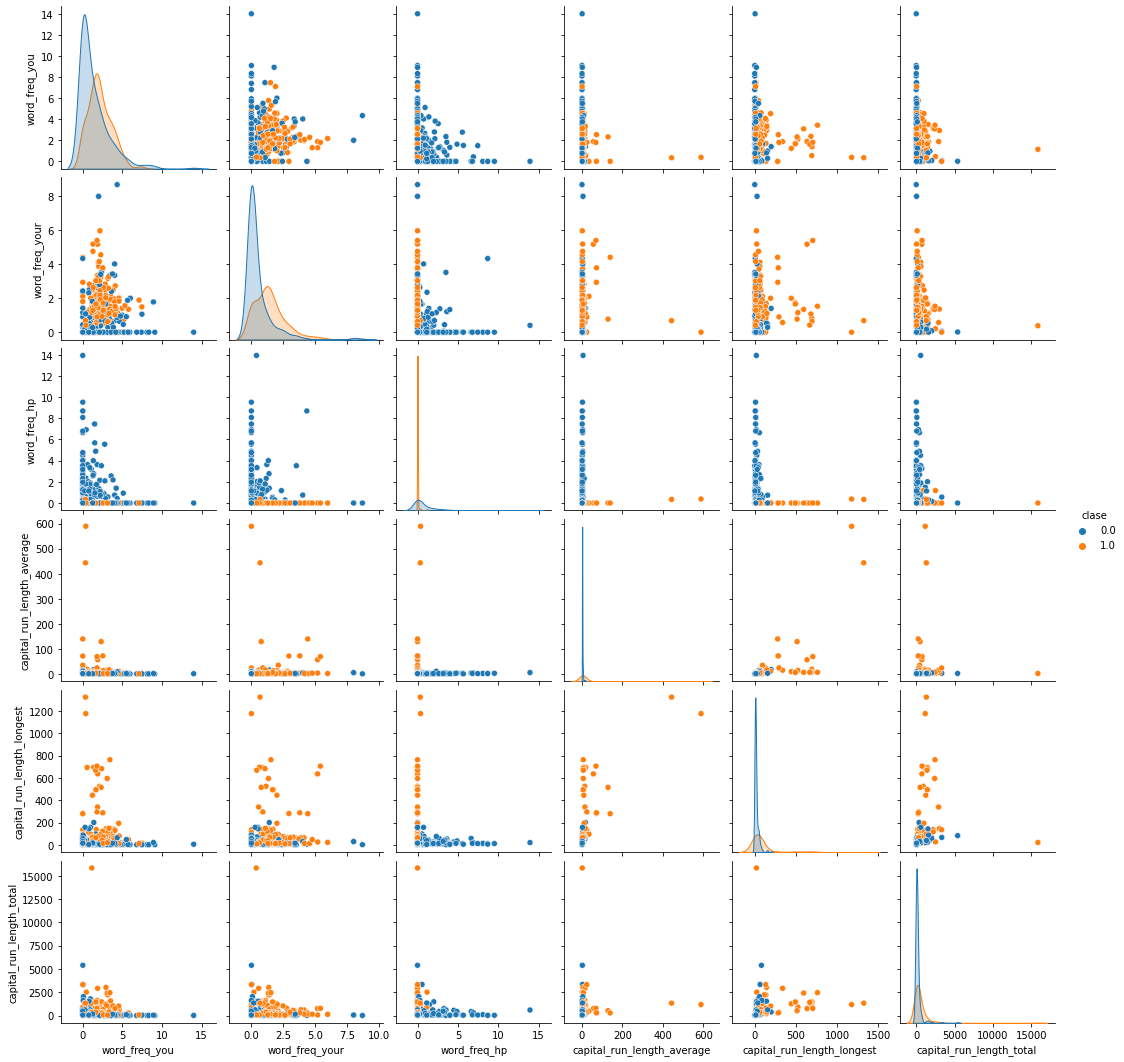

In [ ]:
sns.pairplot(df1.iloc[:,[18,20,24,54,55,56,57]],hue="clase");

Se observa que existen variables gracias a las cuales será posible clasificar de buena manera si el correo es Spam o no, esto es visible en la distribución que presentan variables como frecuencia de aparición de la palabra HP, la Secuencia ininterrumpida de letras mayúsculas (capital_run_length) en sus 3 variables.

# 2. Modelos

Se importan dos modelos de clasificación de distintas familias

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# utilizamos el método fit para ajustar los estimadores (aka modelos). Ver
# link de documentación en párrafo de arriba para entender mejor la lógica
# de los modelos como objetos
modelo_reg_logistica = LogisticRegression(random_state=SEED).fit(X_train, y_train.values.ravel())
modelo_naive_bayes = GaussianNB().fit(X_train, y_train.values.ravel())

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


El `.fit()` método toma los datos de entrenamiento como argumentos, que pueden ser una matriz en el caso del aprendizaje no supervisado o dos matrices en el caso del aprendizaje supervisado.

In [ ]:
reg_logistica_preds = modelo_reg_logistica.predict(X_test)
naive_bayes_preds = modelo_naive_bayes.predict(X_test)

Primeras 4 predicciones del modelo de `regresión logistica` y sus etiquetas.

In [ ]:
reg_logistica_preds[:4]

array([1, 1, 0, 0])

In [ ]:
pd.Series(reg_logistica_preds).replace(labels)[:4]

0      Spam
1      Spam
2    NoSpam
3    NoSpam
dtype: object

Primeras 4 predicciones del modelo de `naive_bayes` y sus etiquetas.

In [ ]:
naive_bayes_preds[:4]

array([1, 1, 0, 1])

In [ ]:
pd.Series(naive_bayes_preds).replace(labels)[:4]

0      Spam
1      Spam
2    NoSpam
3      Spam
dtype: object

Es posible empezar a observar las primeras diferencias en ambos métodos de predicción.

# 3. Métricas

#### Accuracy

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

print(f'Desempeño regresión logistica según accuracy: {accuracy_score(y_test, reg_logistica_preds)}')
print(f'Desempeño naive bayes según accuracy: {accuracy_score(y_test, naive_bayes_preds)}')

Desempeño regresión logistica según accuracy: 0.88
Desempeño naive bayes según accuracy: 0.85


El accuracy en la `Regrecion Logistica` quiere decir que el modelo clasifico correctamente el 88% de las observaciones.

El accuracy en `Gaussian Naive Bayes` quiere decir que el modelo clasifico correctamente el 85% de las observaciones.

#### f1-score

In [ ]:
print(f'Desempeño regresión logistica según f1-score: {f1_score(y_test, reg_logistica_preds, average="weighted")}')
print(f'Desempeño naive bayes según f1-score: {f1_score(y_test, naive_bayes_preds, average="weighted")}')

Desempeño regresión logistica según f1-score: 0.8796059113300493
Desempeño naive bayes según f1-score: 0.8504954459013112


El f1-score en la `Regrecion Logistica` quiere decir que el modelo clasifico el 87,96% de las observaciones de forma correcta considerenado los falsos positivos y los falsos negativos.

El f1-score en `Gaussian Naive Bayes` quiere decir que el modelo clasifico correctamente el 85,04% de las observaciones de forma correcta considerenado los falsos positivos y los falsos negativos.

#### Matriz de confusión

In [ ]:
confusion_matrix(y_test, reg_logistica_preds)

array([[52,  5],
       [ 7, 36]])

In [ ]:
confusion_matrix(y_test, naive_bayes_preds)

array([[44, 13],
       [ 2, 41]])

In [ ]:
def plot_matriz_confusion(cf, CMAP='Blues_r'):
    """Recibe un array con la matriz de confusion"""
    classes = ['NoSpam','Spam']
    df_cm_log = pd.DataFrame(cf / np.sum(cf) * 100,
                             index = [i for i in classes],
                             columns = [i for i in classes])
    sns.heatmap(df_cm_log, annot=True, cmap=CMAP, linewidth=.5,
                linecolor='lightgrey', annot_kws={'size': 8.5},);

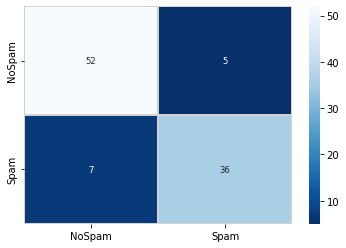

In [ ]:
plot_matriz_confusion(confusion_matrix(y_test, reg_logistica_preds))

Interpretación de la `matriz de confusión` de la `regresión logística`:
- 52 observaciones fueron clasificadas correctamente como No Spam.
- 5 observaciones que eran No Spam, fueron clasificadas erróneamente como Spam.
- 7 observaciones que eran Spam, fueron clasificadas erróneamente como No Spam.
- 36 observaciones fueron clasificadas correctamente como Spam.

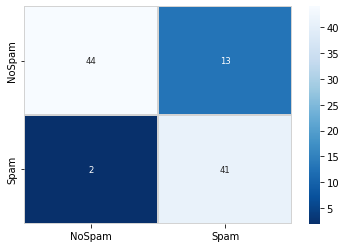

In [ ]:
plot_matriz_confusion(confusion_matrix(y_test, naive_bayes_preds))

Interpretación de la `matriz de confusión` de la `Gaussian Naive Bayes`:
- 44 observaciones fueron clasificadas correctamente como No Spam.
- 13 observaciones que eran No Spam, fueron clasificadas erróneamente como Spam.
- 2 observaciones que eran Spam, fueron clasificadas erróneamente como No Spam.
- 41 observaciones fueron clasificadas correctamente como Spam.

In [ ]:
y_test.value_counts()

0    57
1    43
Name: clase, dtype: int64

Utilizaremos la función `classification_report` que nos
entrega un _overview_ del modelo:

In [ ]:
print(classification_report(y_test, naive_bayes_preds))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85        57
           1       0.76      0.95      0.85        43

    accuracy                           0.85       100
   macro avg       0.86      0.86      0.85       100
weighted avg       0.87      0.85      0.85       100



In [ ]:
print(classification_report(y_test, reg_logistica_preds))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90        57
           1       0.88      0.84      0.86        43

    accuracy                           0.88       100
   macro avg       0.88      0.87      0.88       100
weighted avg       0.88      0.88      0.88       100



Finalmente se puede concluir que un modelo será mejor dependiendo el objetivo final que se persiga, el método de Gaussian Naive Bayes es mejor clasificando correos Spam. Sin embargo también clasifica una mayor cantidad de correos que no lo son a esta categoría. En términos generales la regresión logística es la que comete menos errores considerando correos Spam y No Spam.

-	Accuracy y F1-scored respaldan el echo de que la regresión logística es el mejor modelo clasificador.
-	Gaussian Naive Bayes clasifica de mejor manera la categoría que nos interesa.
